In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [2]:
# データの中身を見てみる

df_train = pd.read_csv('train.csv')

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# NumPyの配列にする

X_train = df_train.drop('label', axis=1).values.astype('float32')
y_train = df_train['label'].values

X_train.shape, y_train.shape

((42000, 784), (42000,))

Label:  8


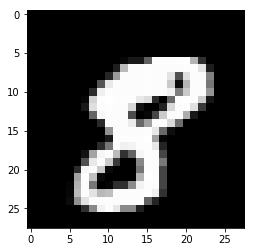

In [4]:
# 適当に取り出して中身を見てみる

print('Label: ', y_train[10])
plt.imshow(X_train[10].reshape(28, 28), cmap='gray');

In [5]:
# 何も考えず生データを学習させてみる
# 42000サンプルあってLogisticRegressionによるバッチ学習は困難なので確率的勾配降下法を使う

# loss='log' とすることでロジスティック回帰モデルになる
clf = SGDClassifier(loss='log', n_iter=10, n_jobs=-1, random_state=1)

# 性能評価のために5-fold cross　validationを行う
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('CV accuracy: {: .3f} +/- {: .3f}'.format(scores.mean(), scores.std()))

CV accuracy:  0.862 +/-  0.023


Scaling 0: mean= 0.131, std= 0.309
Scaling 1: mean=-0.000, std= 0.950


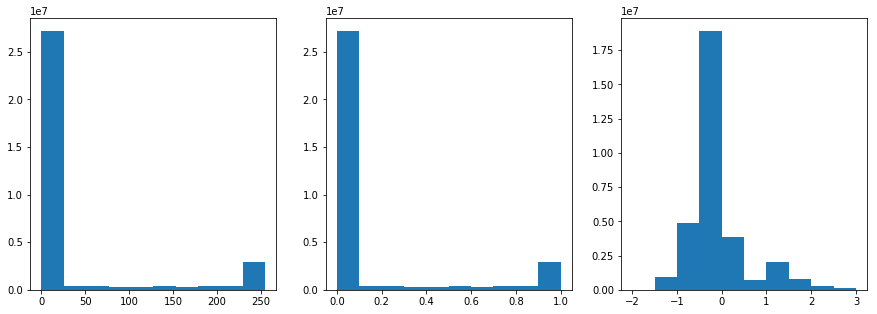

In [6]:
X_train_scaled0 = X_train / 255

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train)

print('Scaling 0: mean={: .3f}, std={: .3f}'.format(X_train_scaled0.mean(), X_train_scaled0.std()))
print('Scaling 1: mean={: .3f}, std={: .3f}'.format(X_train_scaled1.mean(), X_train_scaled1.std()))


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(X_train.flatten())
plt.subplot(1, 3, 2)
plt.hist(X_train_scaled0.flatten(), range=(0, 1))
plt.subplot(1, 3, 3)
plt.hist(X_train_scaled1.flatten(), range=(-2, 3));

In [7]:
# [0, 1] 区間にスケーリングしたやつで学習させてほうが性能がいい

clf1 = SGDClassifier(loss='log', n_iter=10, n_jobs=-1, random_state=1)
scores1 = cross_val_score(clf1, X_train_scaled0, y_train, cv=5)
print('CV accuracy: {: .3f} +/- {: .3f}'.format(scores1.mean(), scores1.std()))

CV accuracy:  0.897 +/-  0.005


In [8]:
# StandardScaler を使ったやつはもっといい（こっちの理由はよくわからない）
# 上のn_iterを20にするともっと精度があがる

clf2 = SGDClassifier(loss='log', n_iter=10, n_jobs=-1, random_state=1)
scores2 = cross_val_score(clf2, X_train_scaled1, y_train, cv=5)
print('CV accuracy: {: .3f} +/- {: .3f}'.format(scores2.mean(), scores2.std()))

CV accuracy:  0.911 +/-  0.001


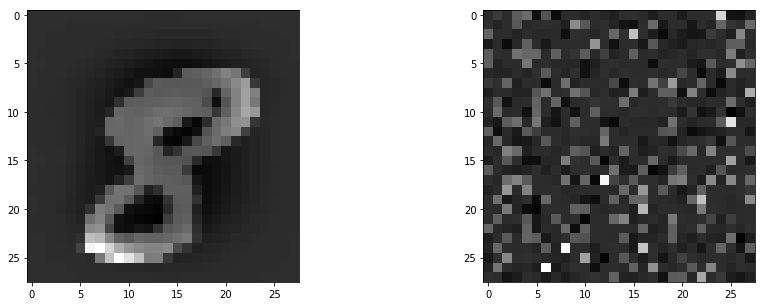

In [9]:
# ピクセルをシャッフルした教師データで試してみる

X_train_shuffled = np.random.permutation(X_train_scaled1.T).T

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_scaled1[10].reshape(28, 28), cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(X_train_shuffled[10].reshape(28, 28),cmap='gray');

In [10]:
# まったく同じ精度が出た。ロジスティック回帰モデルの意味を考えればこれは当然

clf3 = SGDClassifier(loss='log', n_iter=10, n_jobs=-1, random_state=1)
scores3 = cross_val_score(clf2, X_train_shuffled, y_train, cv=5)
print('CV accuracy: {: .3f} +/- {: .3f}'.format(scores2.mean(), scores2.std()))

CV accuracy:  0.911 +/-  0.001


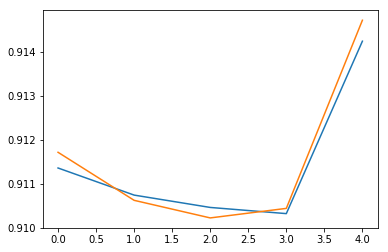

In [11]:
# Cross validation の各スコアもほぼ等しい
# 微妙な違いは浮動小数点数演算の丸め誤差に起因していると考えられる

plt.plot(scores2)
plt.plot(scores3);

In [12]:
# たとえば各要素は等しいが平均を計算すると微妙に誤差が出る

print(np.all(np.unique(X_train_scaled1[10]) ==  np.unique(X_train_shuffled[10])))
print(X_train_scaled1[10].mean(), X_train_shuffled[10].mean())

True
0.214104 0.214104


In [13]:
# Kerasで多層パーセプトロン

np.random.seed(1337)

model = Sequential([
    Dense(32, input_dim=784),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

config = model.get_config()
model1 = Sequential.from_config(config)

model1.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [14]:
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(y_train)

In [15]:
model.fit(X_train_scaled1, y_train_one_hot);

Epoch 1/10
42000/42000 [==============================] - 4s - loss: 0.5082 - acc: 0.8546       

In [16]:
# シャッフルしても同じ結果が出ることを確認
model1.fit(X_train_shuffled, y_train_one_hot);

Epoch 1/10
42000/42000 [==============================] - 4s - loss: 0.5103 - acc: 0.8567           

In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 32)            25120       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            330         activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 10)            0           dense_2[0][0]                    
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_____________________